# Mitsubishi reverse cycle heat pump

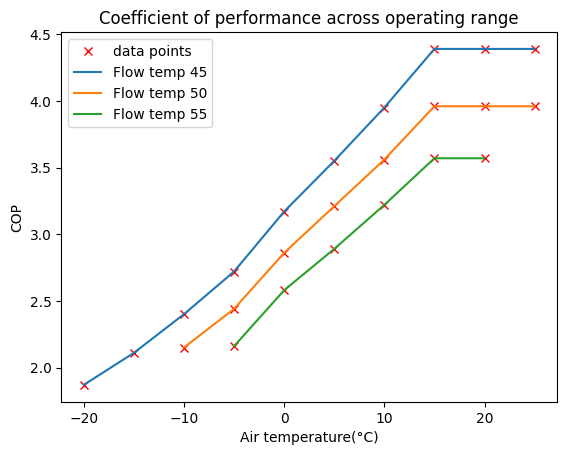

In [12]:
from Modules.Heating import Heat_Pump
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

# Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")

# COP_interp = Heat_Pump.interp_init("COP")

# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Flow temperature(°C)") 

data_COP = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "COP") 
# data_COP = Heat_Pump.interp_call(data_flow_temp, data_air_temp, COP_interp)

# Only Plotting 7 degree line
indices = [i for i, x in enumerate(data_flow_temp) if x < 45]

data_air_temp = np.delete(data_air_temp, indices)
data_flow_temp = np.delete(data_flow_temp, indices)
data_COP = np.delete(data_COP, indices)

plt.plot(data_air_temp, data_COP, label="data points", marker='x', color='red', linestyle='None')

# creating lines between points
flow_temps = np.unique(data_flow_temp)
for flow_temp in flow_temps:
    indices = [i for i, x in enumerate(data_flow_temp) if x == flow_temp]
    plt.plot(data_air_temp[indices], data_COP[indices], label="Flow temp " + str(flow_temp), linestyle='solid')

plt.title('Coefficient of performance across operating range')
plt.xlabel('Air temperature(°C)')
plt.ylabel('COP')
plt.legend()

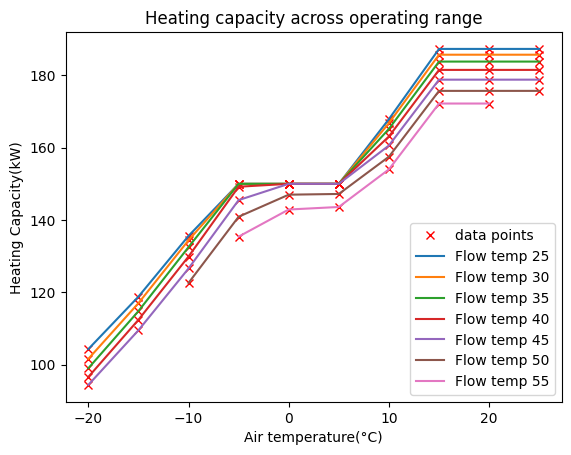

In [2]:
from Modules.Heating import Heat_Pump
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Flow temperature(°C)") 

data_capacity = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Heating capacity (kW)") 

plt.plot(data_air_temp, data_capacity, label="data points", marker='x', color='red', linestyle='None')

# creating lines between points
flow_temps = np.unique(data_flow_temp)
for flow_temp in flow_temps:
    indices = [i for i, x in enumerate(data_flow_temp) if x == flow_temp]
    plt.plot(data_air_temp[indices], data_capacity[indices], label="Flow temp " + str(flow_temp), linestyle='solid')

plt.title('Heating capacity across operating range')
plt.xlabel('Air temperature(°C)')
plt.ylabel('Heating Capacity(kW)')
plt.legend()

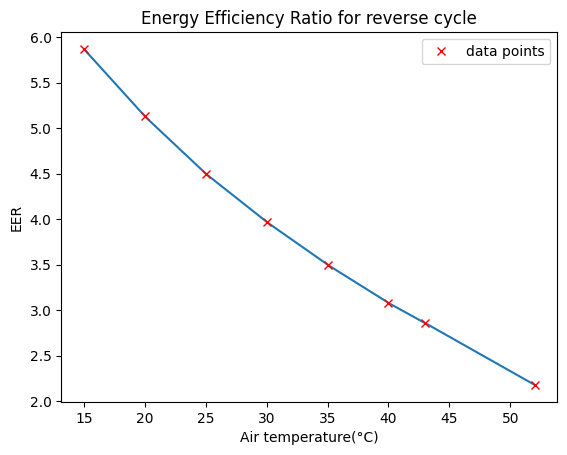

In [5]:
from Modules.Heating import HVAC
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")

EER_interp = HVAC.interp_init("EER")

air_temp = np.linspace(15, 52, 1000)
hydronics_temp = [7]

for flow_temp in hydronics_temp:

    EER = HVAC.interp_call(flow_temp, air_temp, EER_interp)
    
    # plt.plot(air_temp, EER, label = 'Flow temp ' + str(flow_temp) + '°C')
    plt.plot(air_temp, EER)
    
# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "Flow temperature(°C)") 

data_EER = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "EER") 
# data_EER = HVAC.interp_call(data_flow_temp, data_air_temp, EER_interp)

# Only Plotting 7 degree line
indices = [i for i, x in enumerate(data_flow_temp) if x != 7]

data_air_temp = np.delete(data_air_temp, indices)
data_flow_temp = np.delete(data_flow_temp, indices)
data_EER = np.delete(data_EER, indices)

plt.plot(data_air_temp, data_EER, label="data points", marker='x', color='red', linestyle='None')

plt.title('Energy Efficiency Ratio for reverse cycle')
plt.xlabel('Air temperature(°C)')
plt.ylabel('EER')
plt.legend()

Number of fan coils required: 63
Total heating electricity usage 89525.53 kWh/yr
Heating provided by HP 277733.23 kWh/yr
Electricity draw by HP 84790.19 kWh/yr
Heating provided by EB 4735.34 kWh/yr
Electric Boiler size  87.64 kW
Effective COP: 3.16
Total cooling electricity usage 63086.24205144674 kWh/yr
Effective EER: 4.95


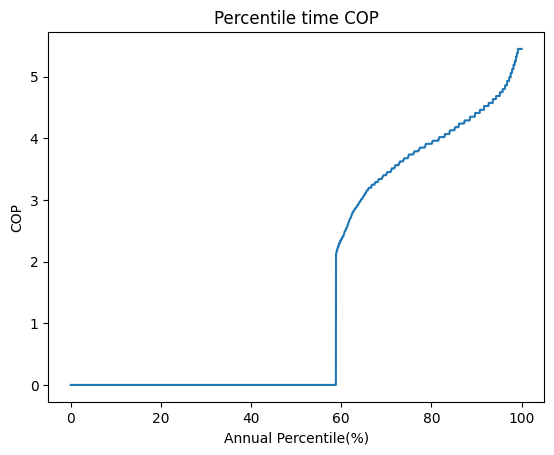

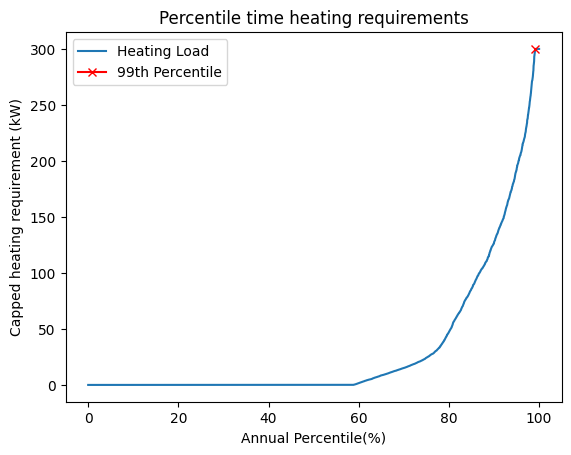

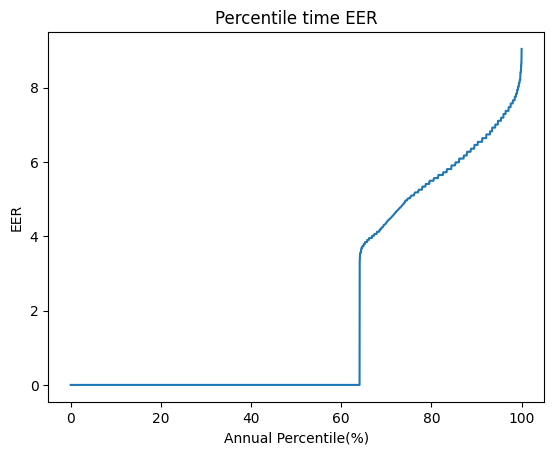

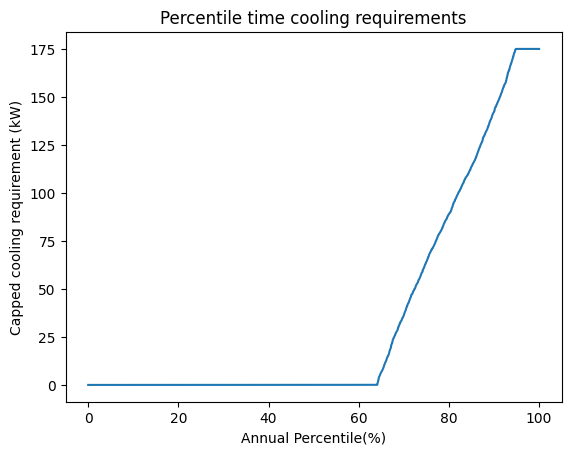

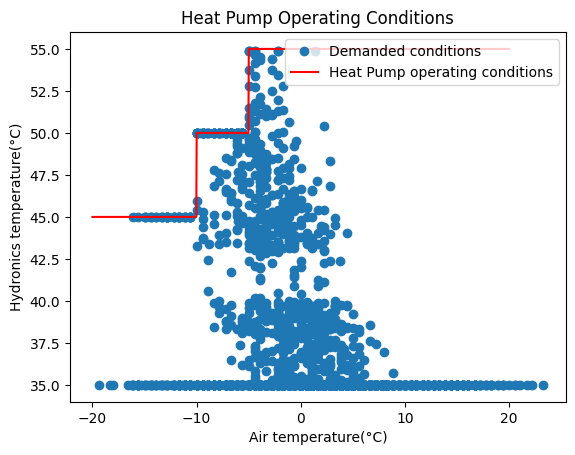

In [13]:
from Modules.Heating import Heat_Pump
from Modules.Heating import HVAC
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Heating_Distribution
import Modules.Data as Data
import numpy as np
import matplotlib.pyplot as plt

# np.set_printoptions(threshold=np.inf)

max_Heating_power = 300 # in kW
max_HVAC_power = 175 # in kW
Heat_Pump_count = 2

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")
HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")
data_path = "Data/XL-BES-Tool_Output_17-02.csv"
write_path = "Data/Output-Alt3.csv"

Heating_Distribution = Heating_Distribution("Data/HFP-550LM-Z1", max_Heating_power, max_HVAC_power)

Controller = Reverse_HP_Controller(data_path, Heat_Pump, Heat_Pump_count, HVAC, Heating_Distribution, max_Heating_power, max_HVAC_power)

(
    time, air_temp,
    heating, heating_electricity,
    heating_hydronics_temp, HP_deliver_temp,
    HP_heating, HP_electricity_demand, COP,
    boiler_power,
    cooling, cooling_electricity, cooling_hydronics_temp, EER
) = Controller.controller()

# Write to csv
Data.write_to_csv(data_path, write_path, "Energy_Heating(kW)", np.round(HP_electricity_demand + boiler_power, decimals=2))
# each column is written individually so second time around read from
# file that was previously written to
Data.write_to_csv(write_path, write_path, "Energy_Cooling(kW)", np.round(cooling_electricity, decimals=2))

# HP system
print('Total heating electricity usage ' + str(round(np.sum(heating_electricity), 2)) + ' kWh/yr')
print('Heating provided by HP ' + str(round(np.sum(HP_heating), 2)) + ' kWh/yr')
print('Electricity draw by HP ' + str(round(np.sum(HP_electricity_demand), 2)) + ' kWh/yr')
print('Heating provided by EB ' + str(round(np.sum(boiler_power), 2)) + ' kWh/yr')
print('Electric Boiler size  ' + str(round(np.max(boiler_power), 2)) + ' kW')

effective_COP = round(np.sum(heating) / np.sum(heating_electricity), 2)
print('Effective COP: ' + str(effective_COP))

# HVAC system
print('Total cooling electricity usage ' + str(np.sum(cooling_electricity)) + ' kWh/yr')

effective_EER = round(np.sum(cooling) / np.sum(cooling_electricity), 2)
print('Effective EER: ' + str(effective_EER))

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

# When cooling is zero set EER to 0
indices = [i for i, x in enumerate(cooling) if x == 0]
EER[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')

plt.figure(1)
plt.plot(100 * time / np.max(time), np.sort(heating), label='Heating Load')
plt.plot(99, max_Heating_power, marker='x', color='red', label='99th Percentile')
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')
plt.legend()

plt.figure(2)
plt.plot(100 * time / np.max(time), np.sort(EER))
plt.title("Percentile time EER")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('EER')

plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(cooling))
plt.title('Percentile time cooling requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped cooling requirement (kW)')

plt.figure(4)
indices = [i for i, x in enumerate(heating) if x != 0]
plt.plot(air_temp[indices], HP_deliver_temp[indices], marker="o", label="Demanded conditions", linestyle="None")
air_temp_op_conditions = np.linspace(-20, 20, 1000)
hydronics_temp_op_conditions = np.ones(len(air_temp_op_conditions)) * 55
hydronics_temp_op_conditions = Heat_Pump.operating_conditions_check(hydronics_temp_op_conditions, air_temp_op_conditions)
plt.plot(air_temp_op_conditions, hydronics_temp_op_conditions, color="red", label="Heat Pump operating conditions")
plt.xlabel("Air temperature(°C)")
plt.ylabel("Hydronics temperature(°C)")
plt.title("Heat Pump Operating Conditions")
plt.legend(loc='upper right')

# Constant Temperature Hydronics System

Total heating electricity usage 114585.49 kWh/yr
Heating provided by HP 277692.32 kWh/yr
Electricity draw by HP 109809.23 kWh/yr
Heating provided by EB 4776.25 kWh/yr
Electric Boiler size  87.64 kW
Effective COP: 2.47
Total cooling electricity usage 68587.06211226032 kWh/yr
Effective EER: 4.55


(34.0, 56.0)

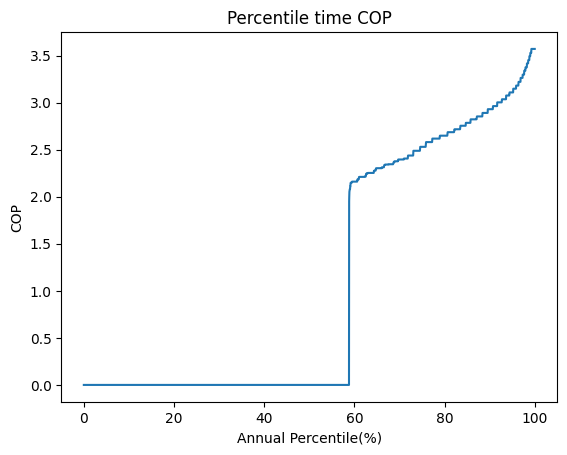

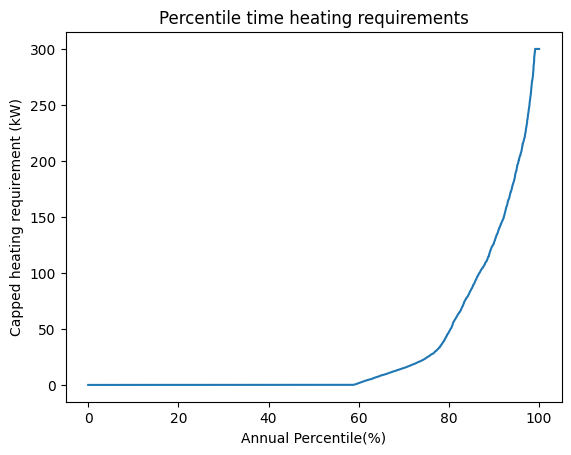

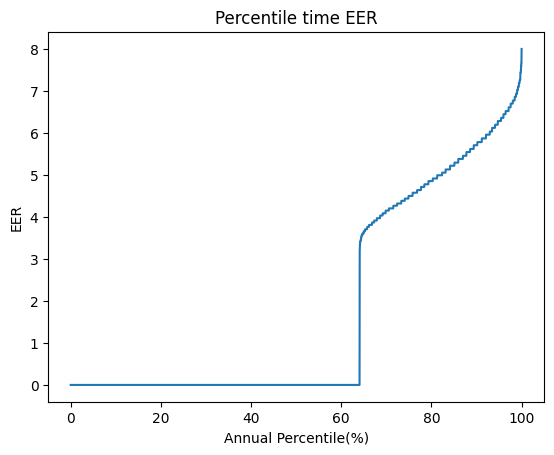

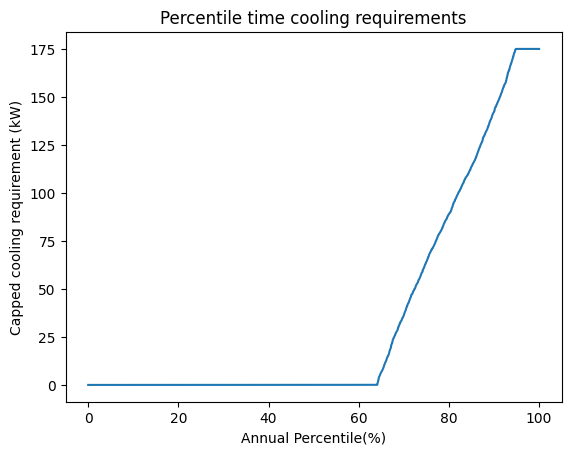

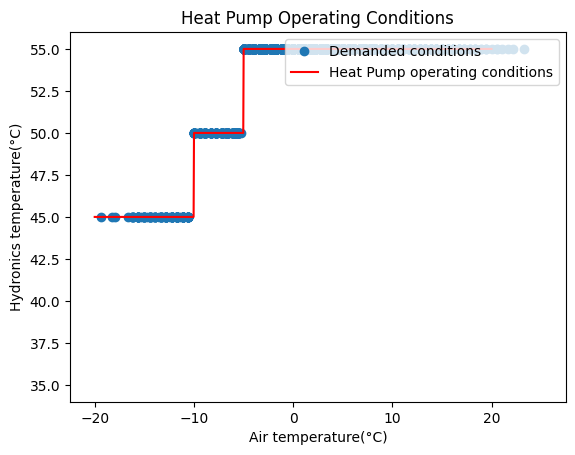

In [ ]:
from Modules.Heating import Heat_Pump
from Modules.Heating import HVAC
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Const_Temp_Heating_Distribution as Heating_Distribution
import numpy as np
import matplotlib.pyplot as plt

max_Heating_power = 300 # in kW
max_HVAC_power = 175 # in kW
Heat_Pump_count = 2
heating_hydronics_temp = 55
cooling_hydronics_temp = 7

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")
HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")
data_path = "Data/XL-BES-Tool_Output_17-02.csv"
write_path = "Data/Output-Alt2.csv"

Heating_Distribution = Heating_Distribution(heating_hydronics_temp, cooling_hydronics_temp)

Controller = Reverse_HP_Controller(data_path, Heat_Pump, Heat_Pump_count, HVAC, Heating_Distribution, max_Heating_power, max_HVAC_power)

(
    time, air_temp,
    heating, heating_electricity,
    heating_hydronics_temp, HP_deliver_temp,
    HP_heating, HP_electricity_demand, COP,
    boiler_power,
    cooling, cooling_electricity, cooling_hydronics_temp, EER
) = Controller.controller()

# write to csv
Data.write_to_csv(data_path, write_path, "Energy_Heating(kW)", np.round(HP_electricity_demand + boiler_power, decimals=2))
# each column is written individually so second time around read from
# file that was previously written to
Data.write_to_csv(write_path, write_path, "Energy_Cooling(kW)", np.round(cooling_electricity, decimals=2))

# HP system
print('Total heating electricity usage ' + str(round(np.sum(heating_electricity), 2)) + ' kWh/yr')
print('Heating provided by HP ' + str(round(np.sum(HP_heating), 2)) + ' kWh/yr')
print('Electricity draw by HP ' + str(round(np.sum(HP_electricity_demand), 2)) + ' kWh/yr')
print('Heating provided by EB ' + str(round(np.sum(boiler_power), 2)) + ' kWh/yr')
print('Electric Boiler size  ' + str(round(np.max(boiler_power), 2)) + ' kW')

effective_COP = round(np.sum(heating) / np.sum(heating_electricity), 2)
print('Effective COP: ' + str(effective_COP))

# HVAC system
print('Total cooling electricity usage ' + str(np.sum(cooling_electricity)) + ' kWh/yr')

effective_EER = round(np.sum(cooling) / np.sum(cooling_electricity), 2)
print('Effective EER: ' + str(effective_EER))

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

# When cooling is zero set EER to 0
indices = [i for i, x in enumerate(cooling) if x == 0]
EER[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')

plt.figure(1)
plt.plot(100 * time / np.max(time), np.sort(heating))
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')

plt.figure(2)
plt.plot(100 * time / np.max(time), np.sort(EER))
plt.title("Percentile time EER")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('EER')

plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(cooling))
plt.title('Percentile time cooling requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped cooling requirement (kW)')

plt.figure(4)
indices = [i for i, x in enumerate(heating) if x != 0]
plt.plot(air_temp[indices], HP_deliver_temp[indices], marker="o", label="Demanded conditions", linestyle="None")
air_temp_op_conditions = np.linspace(-20, 20, 1000)211226032 kWh/yr
hydronics_temp_op_conditions = np.ones(len(air_temp_op_conditions)) * 55
hydronics_temp_op_conditions = Heat_Pump.operating_conditions_check(hydronics_temp_op_conditions, air_temp_op_conditions)
plt.plot(air_temp_op_conditions, hydronics_temp_op_conditions, color="red", label="Heat Pump operating conditions")
plt.xlabel("Air temperature(°C)")
plt.ylabel("Hydronics temperature(°C)")
plt.title("Heat Pump Operating Conditions")
plt.legend(loc='upper right')

ax = plt.gca()
ax.set_xlim([-22.5, 27.5])
ax.set_ylim([34, 56])